In [19]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import  ncx2, shapiro, kstest, norm, ks_2samp

import pandas as pd
from joblib import Parallel, delayed
 

In [20]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx # Number of trajectories
        self.Nt = Nt # Number of discretization steps
        self.init_state = init_state

        #Wiener Process by default
        self.bxt = lambda x: 0
        self.sigmaxt = lambda x: 1
        self.bxt_x = lambda x: 0
        self.bxt_xx = lambda x: 0
        self.sigmaxt_x = lambda x: 0
        self.sigmaxt_xx = lambda x: 0

    def DefaultInitState(self):
        return np.zeros(self.Nx)

    def SampleFromDensity(self, x0, t, t0):
        result = np.zeros(self.Nx)
        for k in range(0, self.Nx):
            result[k] = x0[k] + np.random.normal(0, 1) * np.sqrt(t - t0)
        return result

    def PathGenerator(self):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = self.SampleFromDensity(x_data[i - 1], t_data[i], t_data[i - 1])
        return t_data, x_data

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + dwt[i - 1]
        return t_data, x_data

    def EulerSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
        return t_data, x_data

    def Milstein1Solution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1] + \
                        1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) * (dwt[i - 1]**2 - dt)
        return t_data, x_data

    def Milstein2Solution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + (self.bxt(x_data[i - 1]) - 1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1])) * dt +\
                        self.sigmaxt(x_data[i - 1]) * dwt[i - 1] + 1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) * dwt[i - 1]**2 +\
                        (1/2 * self.bxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) + 1/2 * self.bxt_x(x_data[i - 1]) * self.sigmaxt(x_data[i - 1]) +\
                        1/4 * self.sigmaxt(x_data[i - 1])**2 * self.sigmaxt_xx(x_data[i - 1])) * dt * dwt[i - 1] +\
                        (1/2 * self.bxt(x_data[i - 1]) * self.bxt_x(x_data[i - 1]) + 1/4 * self.bxt_xx(x_data[i - 1]) * self.sigmaxt(x_data[i - 1])**2) * dt**2
        return t_data, x_data

    def PredictorCorrectorSolution(self, dwt, eta = 1/2, alpha = 1/2):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            yw = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
            bwim1 = self.bxt(x_data[i - 1]) - eta * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1])
            bwi = self.bxt(yw) - eta * self.sigmaxt(yw) * self.sigmaxt_x(yw)
            x_data[i] = x_data[i - 1] + alpha * bwi * dt + (1 - alpha) * bwim1 * dt +\
                        eta * self.sigmaxt(yw) * dwt[i - 1] + (1 - eta) * self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
        return t_data, x_data


class OUprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta, mu, sigma]
        self.bxt = lambda x: self.params[0] * (self.params[1] - x)
        self.sigmaxt = lambda x: self.params[2]
        self.bxt_x = lambda x: -self.params[0]

    def DefaultInitState(self):
        return self.params[1] * np.ones(self.Nx)

    def StationaryState(self):
        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            m = mu
            v = sigma**2 / (2 * theta)
            result[j] = np.random.normal(m, np.sqrt(v))
        return result

    def SampleFromDensity(self, x0, t, t0):
        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            m = mu + (x0[j] - mu) * np.exp(-theta * (t - t0))
            v = sigma**2 / (2 * theta) * (1 - np.exp(-2 * theta * (t - t0)))
            result[j] = np.random.normal(m, np.sqrt(v))
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        Ito_integral_sum = np.zeros(self.Nx)
        Determinated_part = mu + (x_data[0] - mu) * np.exp(-theta * t_data)
        for i in range(1, self.Nt + 1):
            Ito_integral_sum += sigma * np.exp(theta * t_data[i - 1]) * dwt[i - 1]
            x_data[i] = Determinated_part[i] + Ito_integral_sum * np.exp(-theta * t_data[i])
        return t_data, x_data


class CIRprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2, theta3]
        self.bxt = lambda x: self.params[0] - self.params[1] * x
        self.sigmaxt = lambda x: self.params[2] * np.sqrt(np.maximum(x, 0))
        self.bxt_x = lambda x: - self.params[1]
        self.sigmaxt_x = lambda x: self.params[2] * 1 / (2 * np.sqrt(np.maximum(x, 0)))
        self.sigmaxt_xx = lambda x: -self.params[2] * 1 / (4 * np.maximum(x, 0)**(1/4))

    def DefaultInitState(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)

    def StationaryState(self):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            c = 2 * k / (sigma**2)
            u = 0
            q = 2 * k * theta / sigma**2 - 1
            result[j] = ncx2.rvs(2 * q + 2, 2 * u) / (2 * c)
        return result

    def SampleFromDensity(self, x0, t, t0):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            c = 2 * k / (sigma**2 * (1 - np.exp(-k * (t - t0))))
            u = c * x0[j] * np.exp(-k * (t - t0))
            #v = c * x
            q = 2 * k * theta / sigma**2 - 1
            result[j] = ncx2.rvs(2 * q + 2, 2 * u) / (2 * c)
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        Ito_integral_sum = np.zeros(self.Nx)
        Determinated_part = (x_data[0] - theta1 / theta2) * np.exp(-theta2 * t_data) + theta1/theta2
        for i in range(1, self.Nt + 1):
            Ito_integral_sum += theta3 * np.exp(theta2 * t_data[i - 1]) * np.sqrt(np.maximum(x_data[i - 1], 0)) * dwt[i - 1]
            x_data[i] = Determinated_part[i] + Ito_integral_sum * np.exp(-theta2 * t_data[i])
        return t_data, x_data


class BSMprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2] or [r, sigma]
        self.bxt = lambda x: self.params[0] * x
        self.sigmaxt = lambda x: self.params[1] * x
        self.bxt_x = lambda x: self.params[0]
        self.sigmaxt_x = lambda x: self.params[1]

    def DefaultInitState(self):
        return np.ones(self.Nx)

    def SampleFromDensity(self, x0, t, t0):
        r = self.params[0]
        sigma = self.params[1]

        result = np.zeros(self.Nx)

        m = (r - 1/2 * sigma**2) * (t - t0)
        v = sigma**2 * (t - t0)

        for j in range(0, self.Nx):
            result[j] = x0[j] * np.random.lognormal(m, np.sqrt(v))
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        r = self.params[0]
        sigma = self.params[1]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] * np.exp((r - sigma**2 / 2) * dt + sigma * dwt[i - 1])
        return t_data, x_data

Task 1. Suppose we have a   Brownian motion  defined by
 $$
 dX_t = \theta_1 X_tdt + \theta_2X_tdW_t, \quad X_0 = 1, \text{ with } (\theta_1, \theta_2) = (2, 0.5).
 $$
Compare approximations
*   the Euler approximation algorithm;
*   the 1st Milstein scheme;
*   the 2nd Milstein scheme;
*   the predictor-corrector method  (set default $\alpha = \eta = 1/2$);
*   KPS method

with the exact solution on $[0,1]$, levels of discretization $N=1024$.

In [21]:
T = 1
Nx = 1
Nt = 1024

x0 = 1
init_state = x0 * np.ones(Nx)

#theta = 2
#mu = 10
#sigma = 3.5
#params = [theta, mu, sigma]

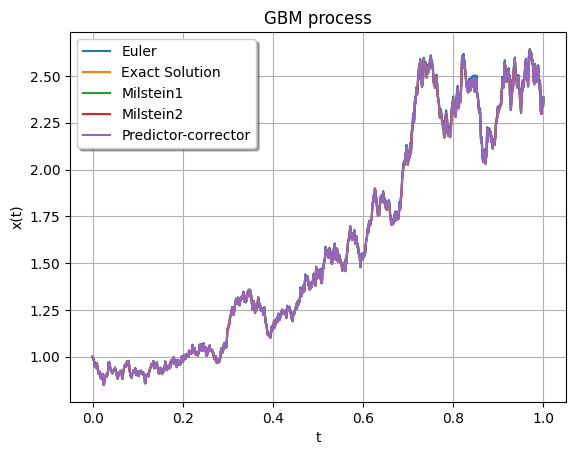

In [22]:
theta1 = 1
theta2 = 1/2
params = [theta1, theta2]

dwt = np.random.normal(0, 1, size = (Nt, Nx)) * np.sqrt(T/Nt)


BSMp = BSMprocess(params, T, Nx, Nt, init_state)
t_data, x_data = BSMp.EulerSolution(dwt)
plt.plot(t_data, x_data, label = 'Euler')

t_data, x_data = BSMp.ExactSolution(dwt)
plt.plot(t_data, x_data, label = 'Exact Solution')

t_data, x_data = BSMp.Milstein1Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein1')

t_data, x_data = BSMp.Milstein2Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein2')

t_data, x_data = BSMp.PredictorCorrectorSolution(dwt, 1/2, 1/2)
plt.plot(t_data, x_data, label = 'Predictor-corrector')

plt.title("GBM process")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task. Compare the different approximations and the exact solution Brownian motion
for different levels of discretization
$$
N=\{2, 4, 8, 128, 256, 512, 1024, 8192, 16384, 32768\}
$$
being the number of subintervals of $[0,1]$.
As the result provide the table with maximum absolute difference.


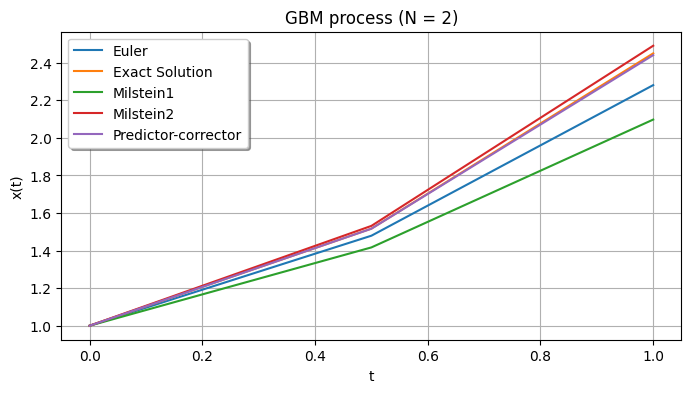

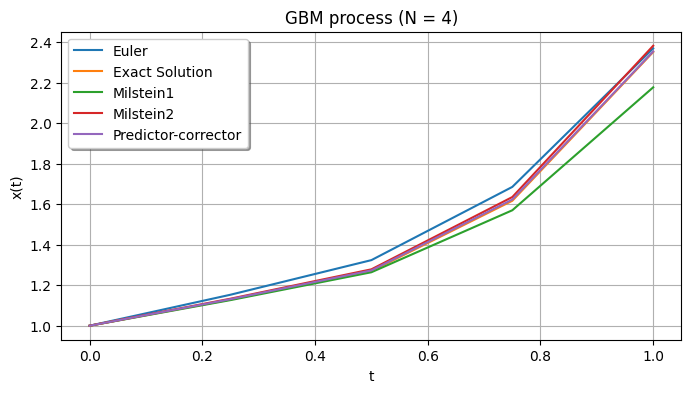

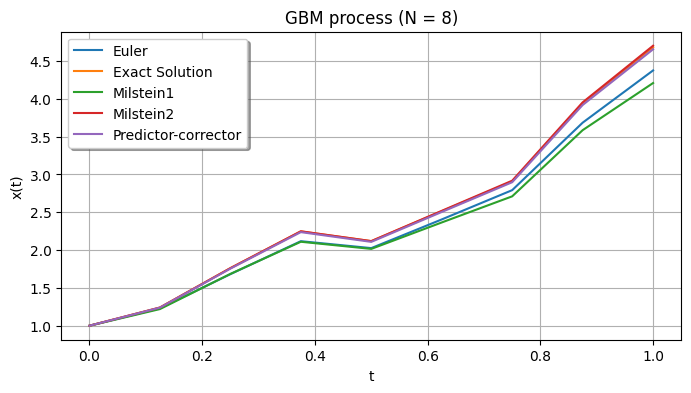

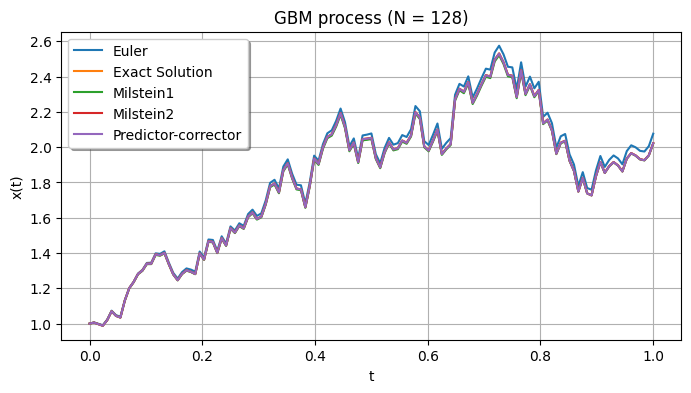

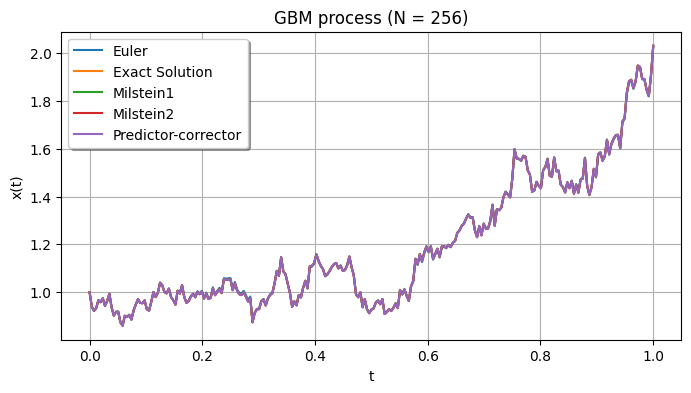

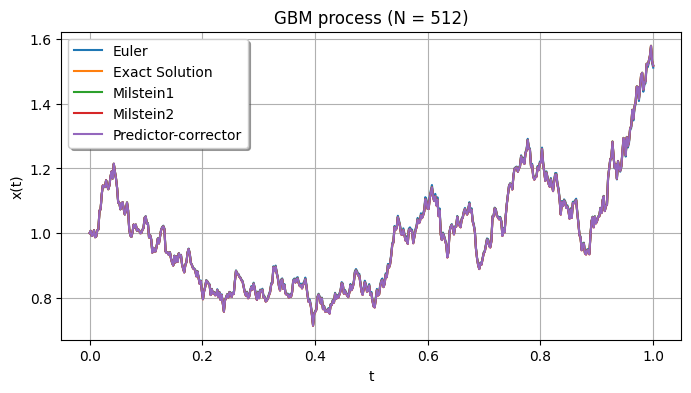

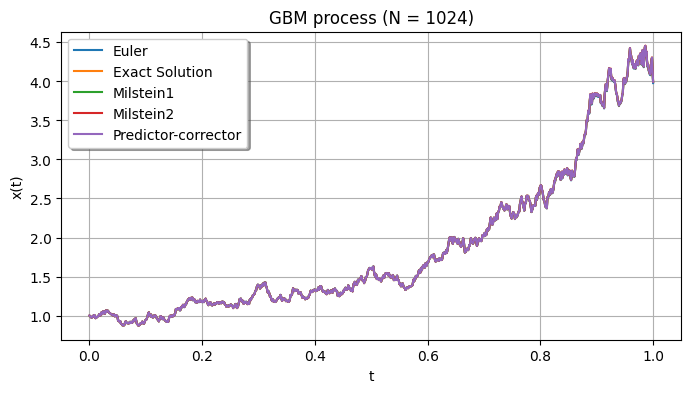

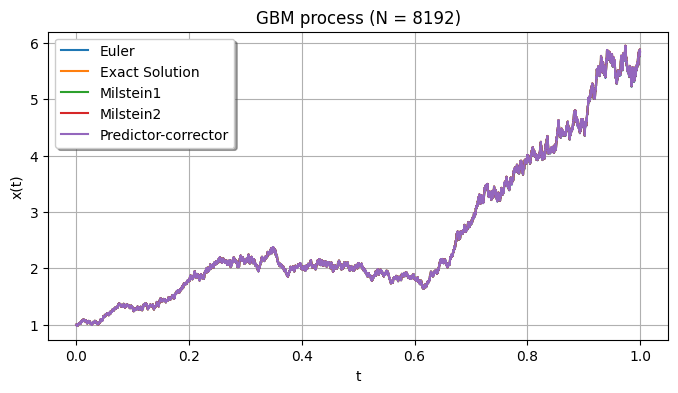

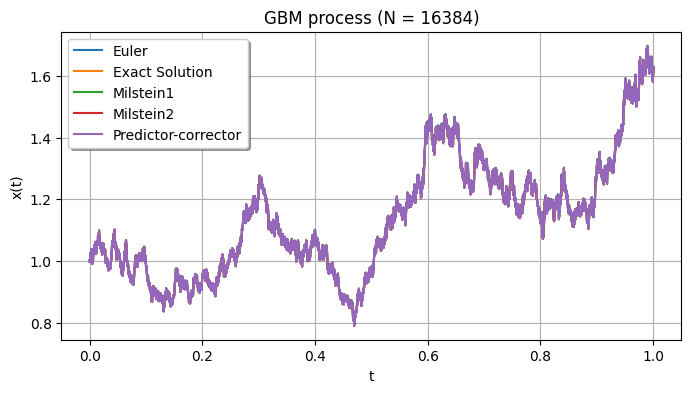

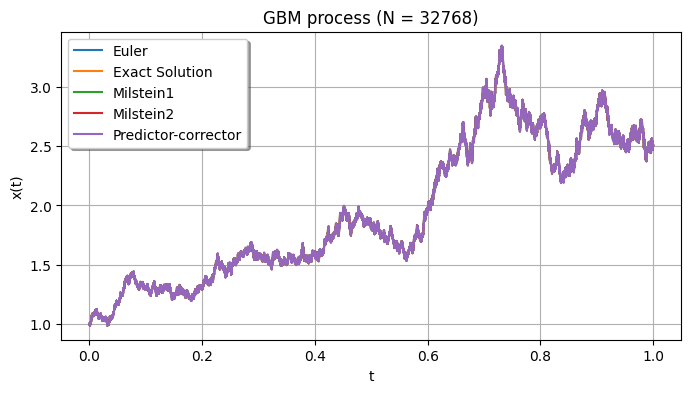

In [5]:

def compare_methods(N, T, params, Nx, init_state):
    
    dwt = np.random.normal(0, 1, size=(N, Nx)) * np.sqrt(T / N)
    BSMp = BSMprocess(params, T, Nx, N, init_state)
    t_data, x_euler = BSMp.EulerSolution(dwt)
    t_data, x_exact = BSMp.ExactSolution(dwt)
    t_data, x_milstein1 = BSMp.Milstein1Solution(dwt)    
    t_data, x_milstein2 = BSMp.Milstein2Solution(dwt)
    t_data, x_predictor = BSMp.PredictorCorrectorSolution(dwt, 1/2, 1/2)

    max_diff_euler = np.max(np.abs(x_exact - x_euler))
    max_diff_milstein1 = np.max(np.abs(x_exact - x_milstein1))
    max_diff_milstein2 = np.max(np.abs(x_exact - x_milstein2))
    max_diff_predictor = np.max(np.abs(x_exact - x_predictor))
    
    
    return {
        'N': N,
        'Max Diff Euler': max_diff_euler,
        'Max Diff Milstein1': max_diff_milstein1,
        'Max Diff Milstein2': max_diff_milstein2,
        'Max Diff Predictor': max_diff_predictor,
        't_data': t_data,
        'x_euler': x_euler,
        'x_exact': x_exact,
        'x_milstein1': x_milstein1,
        'x_milstein2': x_milstein2,
        'x_predictor': x_predictor
    }


theta1 = 1
theta2 = 1/2
params = [theta1, theta2]
T = 1  
Nx = 1  
init_state = np.array([1])  


N_values = [2, 4, 8, 128, 256, 512, 1024, 8192, 16384, 32768]


results = Parallel(n_jobs=-1)(delayed(compare_methods)(N, T, params, Nx, init_state) for N in N_values)


for result in results:
    N = result['N']
    
    
    plt.figure(figsize=(8, 4))
    plt.plot(result['t_data'], result['x_euler'], label='Euler')
    plt.plot(result['t_data'], result['x_exact'], label='Exact Solution')
    plt.plot(result['t_data'], result['x_milstein1'], label='Milstein1')
    plt.plot(result['t_data'], result['x_milstein2'], label='Milstein2')
    plt.plot(result['t_data'], result['x_predictor'], label='Predictor-corrector')

    
    plt.title(f"GBM process (N = {N})")
    plt.legend(loc='best', fancybox=True, shadow=True)
    plt.xlabel("t")
    plt.ylabel("x(t)")
    plt.grid(True)
    
   
    plt.show()


In [7]:
df_results = pd.DataFrame(results)
df_results.head(5)

,N,Max Diff Euler,Max Diff Milstein1,Max Diff Milstein2,Max Diff Predictor,t_data,x_euler,x_exact,x_milstein1,x_milstein2,x_predictor
0,2,0.092304,0.088610,0.016966,0.004140,"[0.0, 0.5, 1.0]","[[1.0], [1.3798307694961012], [1.4424488033065...","[[1.0], [1.3734567944116505], [1.3501446318529...","[[1.0], [1.3245510914760508], [1.4387541400485...","[[1.0], [1.3894664762241014], [1.3671108878408...","[[1.0], [1.3775967646773484], [1.3534785066399..."
1,4,0.189051,0.212881,0.023719,0.043868,"[0.0, 0.25, 0.5, 0.75, 1.0]","[[1.0], [1.625560938273789], [1.53889292735344...","[[1.0], [1.8117820850477455], [1.6648669027048...","[[1.0], [1.6648339474523333], [1.6006287400339...","[[1.0], [1.7899741820207804], [1.6411477248113...","[[1.0], [1.7801997923602526], [1.6336690325248..."
2,8,0.448657,0.480539,0.010694,0.051543,"[0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0....","[[1.0], [1.4003634242618523], [1.7088918469964...","[[1.0], [1.4692299562627151], [1.8029670634400...","[[1.0], [1.4226509319724587], [1.7203238911654...","[[1.0], [1.4648838600051903], [1.8002921047165...","[[1.0], [1.4617560207531446], [1.7939320469461..."
3,128,0.029013,0.032253,0.001359,0.004385,"[0.0, 0.0078125, 0.015625, 0.0234375, 0.03125,...","[[1.0], [0.9315884819925704], [0.9623631416112...","[[1.0], [0.9329645444600317], [0.9633581402409...","[[1.0], [0.9335169699531689], [0.9637406293494...","[[1.0], [0.9329519873906109], [0.9633696623329...","[[1.0], [0.9329853914521378], [0.9633891062683..."
4,256,0.009724,0.006705,0.000589,0.001318,"[0.0, 0.00390625, 0.0078125, 0.01171875, 0.015...","[[1.0], [1.0654248768721226], [1.0362377328877...","[[1.0], [1.067091363975161], [1.03774851235280...","[[1.0], [1.0668288663482384], [1.0376049649465...","[[1.0], [1.0670768028789888], [1.0377237794863...","[[1.0], [1.0670608300086586], [1.0377153827050..."


Task. Conduct a study of the influence of the choice of values $\alpha$ and $\eta$ ​​on the accuracy of the  solution and plot a 3D graph where the x-axis is $α$'s values, y-axis is $\eta$'s values, and z-axis are maximum absolute difference between the exact solution and the predictor-corrector approximation.



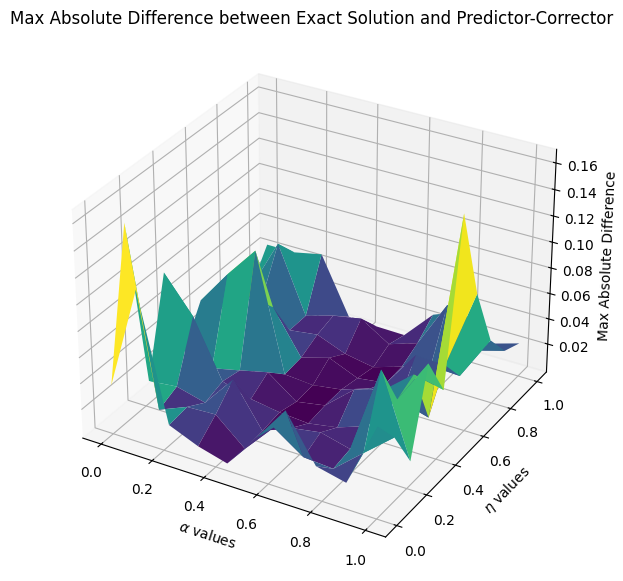

In [23]:
def compute_error(alpha, eta, N, T, params, Nx, init_state):
    
    dwt = np.random.normal(0, 1, size=(N, Nx)) * np.sqrt(T / N)
    

    BSMp = BSMprocess(params, T, Nx, N, init_state)
    
    
    t_data, x_exact = BSMp.ExactSolution(dwt)
    
    
    t_data, x_predictor = BSMp.PredictorCorrectorSolution(dwt, alpha, eta)
    
   
    max_diff = np.max(np.abs(x_exact - x_predictor))
    
    return max_diff


theta1 = 1
theta2 = 1/2
params = [theta1, theta2]
T = 1  
Nx = 1  
init_state = np.array([1]) 
N = 102


alpha_values = np.linspace(0, 1, 10)
eta_values = np.linspace(0, 1, 10)


results = Parallel(n_jobs=-1)(delayed(compute_error)(alpha, eta, N, T, params, Nx, init_state) 
                              for alpha in alpha_values for eta in eta_values)


errors = np.array(results).reshape(len(alpha_values), len(eta_values))


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')


X, Y = np.meshgrid(alpha_values, eta_values)
Z = errors.T 


ax.plot_surface(X, Y, Z, cmap='viridis')


ax.set_xlabel(r'$\alpha$ values')
ax.set_ylabel(r'$\eta$ values')
ax.set_zlabel('Max Absolute Difference')

plt.title('Max Absolute Difference between Exact Solution and Predictor-Corrector')
plt.show()


Task 2.  Repeat the Task 1 for the Cox-Ingersoll-Ross process
$$
dX_t = (\theta_1 - \theta_2X_t)dt + \theta_3 \sqrt{ X_t}dW_t, X_0 = 10, (\theta_1, \theta_2, \theta_3) = (6, 3, 2).
$$

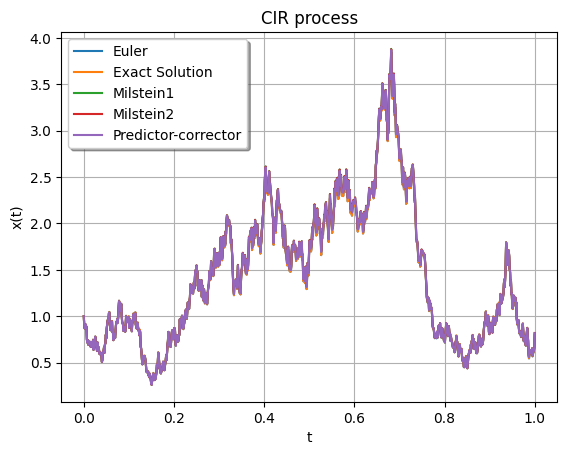

In [24]:
theta1 = 6
theta2 = 3
theta3 = 2
params = [theta1, theta2, theta3]

dwt = np.random.normal(0, 1, size = (Nt, Nx)) * np.sqrt(T/Nt)

CIRp = CIRprocess(params, T, Nx, Nt, init_state)
t_data, x_data = CIRp.EulerSolution(dwt)
plt.plot(t_data, x_data, label = 'Euler')

t_data, x_data = CIRp.ExactSolution(dwt)
plt.plot(t_data, x_data, label = 'Exact Solution')

t_data, x_data = CIRp.Milstein1Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein1')

t_data, x_data = CIRp.Milstein2Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein2')

t_data, x_data = CIRp.PredictorCorrectorSolution(dwt, 0.4, 0.6)
plt.plot(t_data, x_data, label = 'Predictor-corrector')

plt.title("CIR process")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task. Compare the speed of convergence for four schemes from Task 1 with extract solution on the graph where the x-axis is  log(N) values, y-axis is  X(t). See example in the study aid.

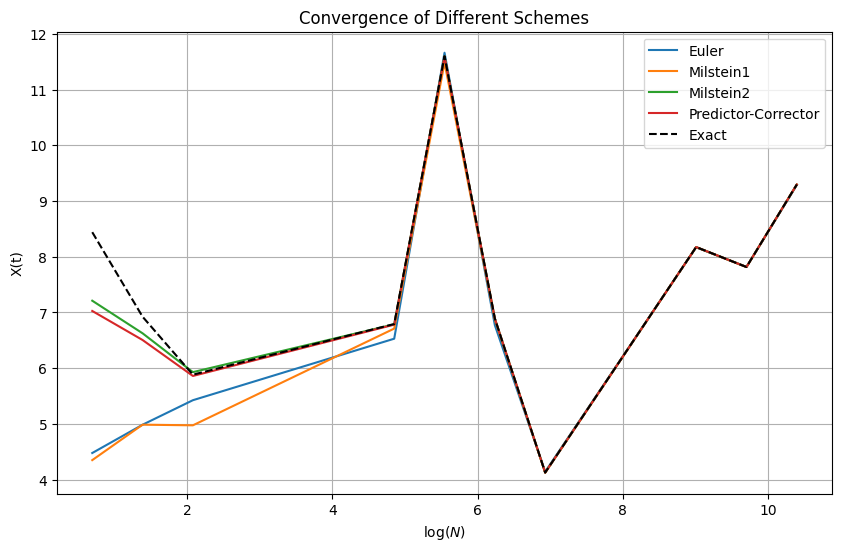

In [32]:
def compute_processes_for_schemes(N, T, params, Nx, init_state):
   
    dwt = np.random.normal(0, 1, size=(N, Nx)) * np.sqrt(T / N)
    
    BSMp = BSMprocess(params, T, Nx, N, init_state)
    
    t_data, x_exact = BSMp.ExactSolution(dwt)
    _, x_euler = BSMp.EulerSolution(dwt)
    _, x_milstein1 = BSMp.Milstein1Solution(dwt)
    _, x_milstein2 = BSMp.Milstein2Solution(dwt)
    _, x_predictor = BSMp.PredictorCorrectorSolution(dwt, 1/2, 1/2)
    
    return {
        'N': N,
        'Euler': x_euler[-1],  
        'Milstein1': x_milstein1[-1],
        'Milstein2': x_milstein2[-1],
        'PredictorCorrector': x_predictor[-1],
        'Exact': x_exact[-1]
    }

theta1 = 2
theta2 = 0.5
params = [theta1, theta2]
T = 1  
Nx = 1  
init_state = np.ones(Nx) * 1.0  

N_values = [2, 4, 8, 128, 256, 512, 1024, 8192, 16384, 32768]

results = Parallel(n_jobs=-1)(delayed(compute_processes_for_schemes)(N, T, params, Nx, init_state) for N in N_values)


euler_processes = [result['Euler'] for result in results]
milstein1_processes = [result['Milstein1'] for result in results]
milstein2_processes = [result['Milstein2'] for result in results]
predictor_processes = [result['PredictorCorrector'] for result in results]
exact_processes = [result['Exact'] for result in results]

log_N_values = np.log(N_values)

plt.figure(figsize=(10, 6))
plt.plot(log_N_values, euler_processes, label='Euler')
plt.plot(log_N_values, milstein1_processes, label='Milstein1')
plt.plot(log_N_values, milstein2_processes, label='Milstein2')
plt.plot(log_N_values, predictor_processes, label='Predictor-Corrector')
plt.plot(log_N_values, exact_processes, label='Exact', linestyle='--', color='black')

plt.title('Convergence of Different Schemes')
plt.xlabel(r'$\log(N)$')
plt.ylabel('X(t)')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [16]:
results

[{'N': 2,
  'Euler': array([4.28193175]),
  'Milstein1': array([4.03789863]),
  'Milstein2': array([6.64898369]),
  'PredictorCorrector': array([6.47779404]),
  'Exact': array([7.49203552])},
 {'N': 4,
  'Euler': array([5.2828093]),
  'Milstein1': array([5.09675737]),
  'Milstein2': array([7.03044887]),
  'PredictorCorrector': array([6.8958441]),
  'Exact': array([7.2987329])},
 {'N': 8,
  'Euler': array([4.31225166]),
  'Milstein1': array([4.42751397]),
  'Milstein2': array([4.89209118]),
  'PredictorCorrector': array([4.84614038]),
  'Exact': array([4.92851725])},
 {'N': 128,
  'Euler': array([7.07286048]),
  'Milstein1': array([7.02096426]),
  'Milstein2': array([7.11384793]),
  'PredictorCorrector': array([7.10751116]),
  'Exact': array([7.11616802])},
 {'N': 256,
  'Euler': array([13.12705344]),
  'Milstein1': array([13.0706339]),
  'Milstein2': array([13.21984049]),
  'PredictorCorrector': array([13.21195994]),
  'Exact': array([13.22235054])},
 {'N': 512,
  'Euler': array([7.009

Task 3. Generate 100 paths using conditional distribution of
* Ornstein-Uhlenbeck process $θ = (1, 1, 0.5)$,
* Geometric Brownian motion process $θ = (0.3, 0.1)$,
* Cox-Ingersoll-Ross process $θ = (0.4, 0.3, 0.2)$

with $X_0=0.5$.
Plot the random path for each process.

In [25]:
Nx = 100
Nt = 300

T = 1

params_OU = [1, 1, 0.5]
params_BSM = [0.3, 0.1]
params_CIR = [0.4, 0.3, 0.2]

init_state = 0.5 * np.ones(Nx)

OUp = OUprocess(params_OU, T, Nx, Nt, init_state)
BSMp = BSMprocess(params_BSM, T, Nx, Nt, init_state)
CIRp = CIRprocess(params_CIR, T, Nx, Nt, init_state)

t_data, x_data_OU = OUp.PathGenerator()
t_data, x_data_BSM = BSMp.PathGenerator()
t_data, x_data_CIR = CIRp.PathGenerator()

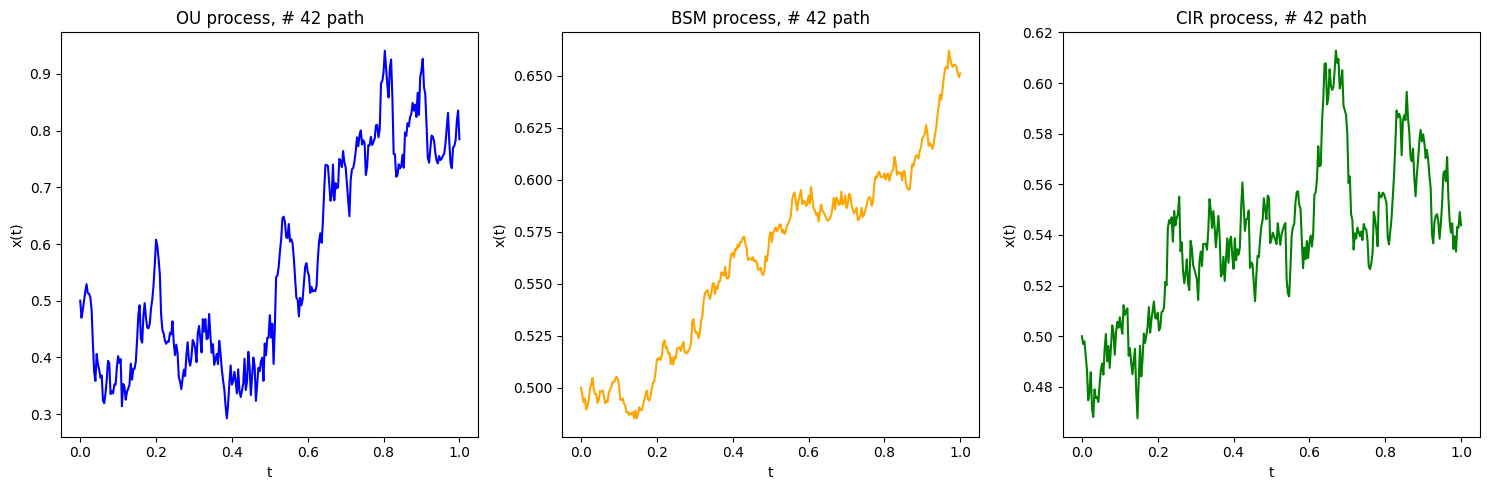

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

n = np.random.randint(0, Nx)

axs[0].plot(t_data, x_data_OU[:,n], color='blue')
axs[0].set_title(f'OU process, # {n} path')
axs[0].set_xlabel('t')
axs[0].set_ylabel('x(t)')

axs[1].plot(t_data, x_data_BSM[:,n], color='orange')
axs[1].set_title(f'BSM process, # {n} path')
axs[1].set_xlabel('t')
axs[1].set_ylabel('x(t)')

axs[2].plot(t_data, x_data_CIR[:,n], color='green')
axs[2].set_title(f'CIR process, # {n} path')
axs[2].set_xlabel('t')
axs[2].set_ylabel('x(t)')

plt.tight_layout()

plt.show()

Task. Using the class template from Task 1, create class and design the path generator for one from the following processes:

1.   Modified CIR model;
2.   Chan-Karolyi-Longstaff-Sanders family of models;
1.   Nonlinear mean reversion Ait-Sahalia model;
2.   Jacobi diffusion process;
1.   Ahn and Gao (inverse of Feller’s square root) model;
2.   Radial Ornstein-Uhlenbeck process.

In [11]:
class JacobiProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta, mu, sigma]
        self.bxt = lambda x: self.params[0] * (self.params[1] - x)
        self.sigmaxt = lambda x: self.params[2] * np.sqrt(np.maximum(x * (1 - x), 0))
        self.bxt_x = lambda x: -self.params[0]
        self.sigmaxt_x = lambda x: self.params[2] * (1 - 2 * x) / (2 * np.sqrt(np.maximum(x * (1 - x), 0)))

    def DefaultInitState(self):
        
        return np.full(self.Nx, self.params[1])

    def SampleFromDensity(self, x0, t, t0):
        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        result = np.zeros(self.Nx)
        for j in range(0, self.Nx):
            m = mu + (x0[j] - mu) * np.exp(-theta * (t - t0))
            v = (sigma**2 * (1 - np.exp(-2 * theta * (t - t0)))) / (2 * theta)
            result[j] = np.random.normal(m, np.sqrt(v))  
            result[j] = np.clip(result[j], 0, 1)  
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            drift = theta * (mu - x_data[i - 1]) * dt
            diffusion = sigma * np.sqrt(np.maximum(x_data[i - 1] * (1 - x_data[i - 1]), 0)) * dwt[i - 1]
            x_data[i] = x_data[i - 1] + drift + diffusion
            x_data[i] = np.clip(x_data[i], 0, 1)  
        return t_data, x_data


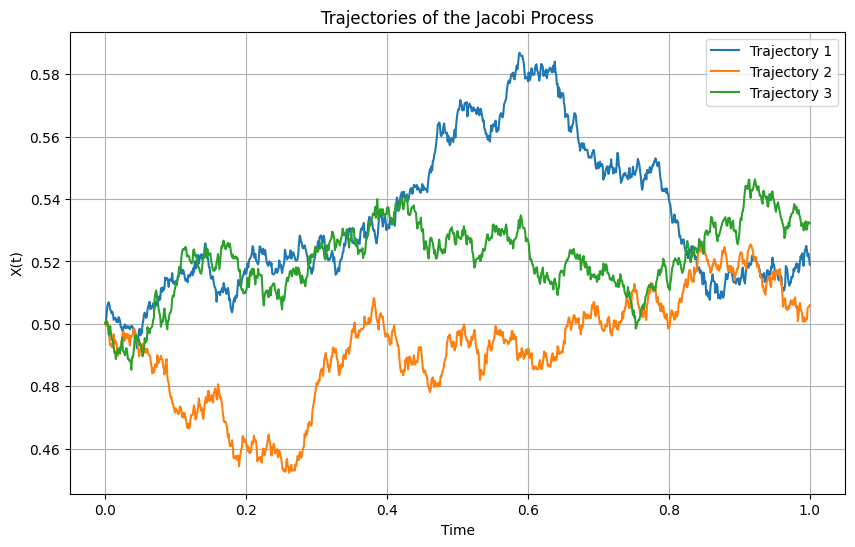

In [12]:
theta = 2.0   
mu = 0.5      
sigma = 0.1   
T = 1.0       
Nx = 3        
Nt = 1000      


params = [theta, mu, sigma]
jacobi_process = JacobiProcess(params, T, Nx, Nt)

np.random.seed(42)  
dwt = np.random.normal(0, np.sqrt(T / Nt), (Nt, Nx))


t_data, x_data = jacobi_process.ExactSolution(dwt)


plt.figure(figsize=(10, 6))
for i in range(Nx):
    plt.plot(t_data, x_data[:, i], label=f"Trajectory {i + 1}")

plt.title("Trajectories of the Jacobi Process")
plt.xlabel("Time")
plt.ylabel("X(t)")
plt.grid(True)
plt.legend()
plt.show()

Task 4. For the processes from previous task plot
* cumulative distribution (cdf),
* density function (pdf),      
* calculate the 90\%-quantile.

In [27]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(len(x))/float(len(x))
    return x, y

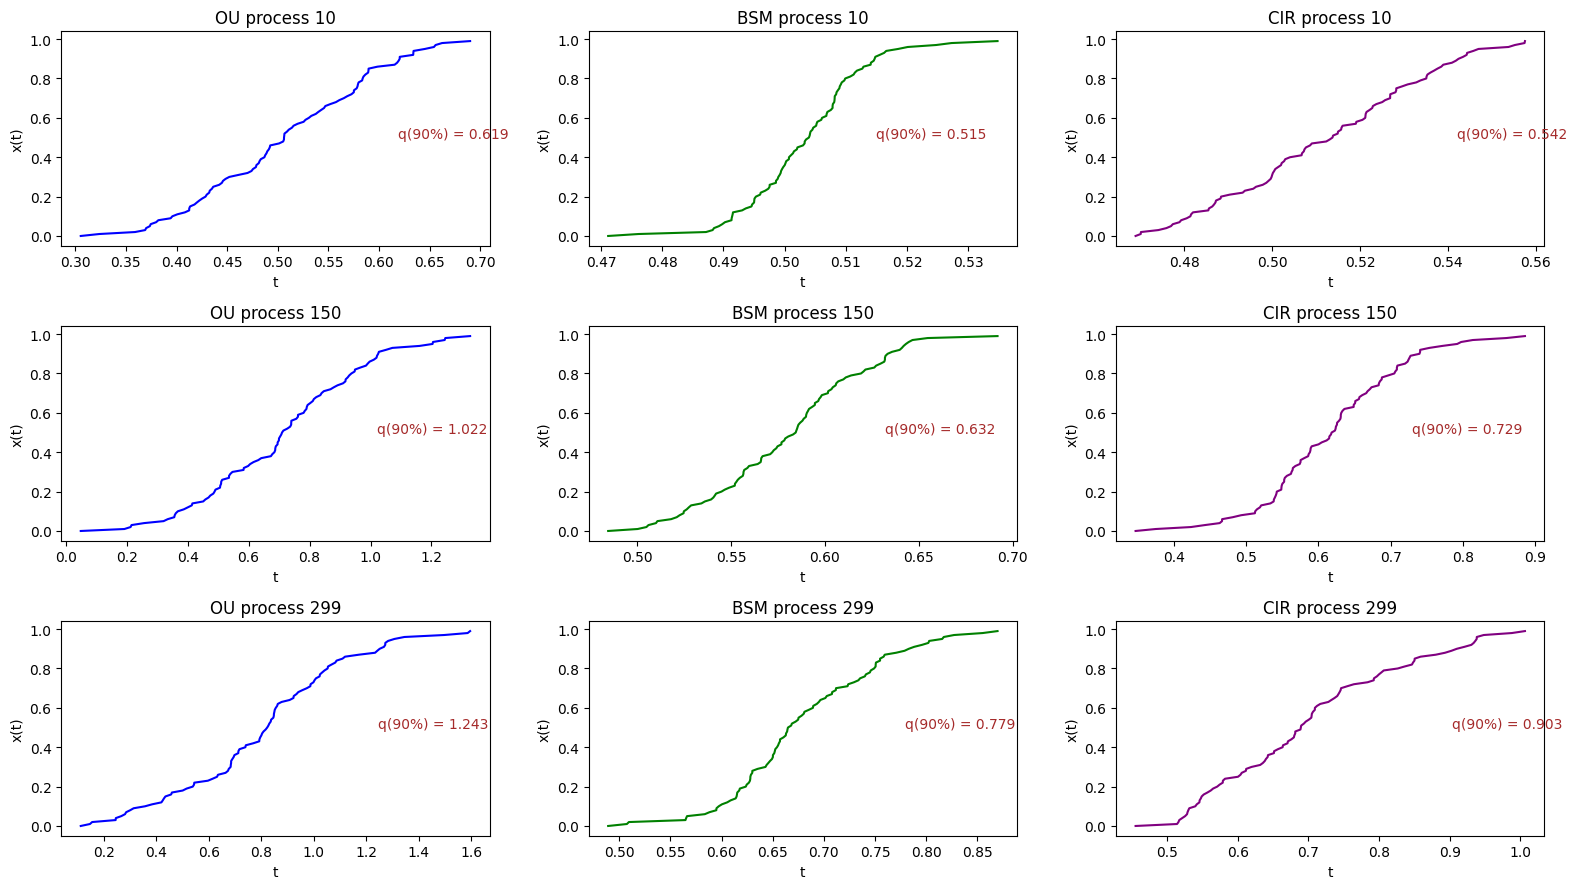

In [28]:
#cdf function and 90% quantile

#distributions become more widely and change with time

fig, axs = plt.subplots(3, 3, figsize=(16, 9))

n = 10

axs[0][0].plot(*ecdf(x_data_OU[n]), color='blue')
axs[0][0].set_title(f'OU process {n}')
val = round(np.quantile(x_data_OU[n], 0.9),3)
axs[0][0].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[0][1].plot(*ecdf(x_data_BSM[n]), color='green')
axs[0][1].set_title(f'BSM process {n}')
val = round(np.quantile(x_data_BSM[n], 0.9),3)
axs[0][1].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[0][2].plot(*ecdf(x_data_CIR[n]), color='purple')
axs[0][2].set_title(f'CIR process {n}')
val = round(np.quantile(x_data_CIR[n], 0.9),3)
axs[0][2].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

n = Nt // 2
axs[1][0].plot(*ecdf(x_data_OU[n]), color='blue')
axs[1][0].set_title(f'OU process {n}')
val = round(np.quantile(x_data_OU[n], 0.9),3)
axs[1][0].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[1][1].plot(*ecdf(x_data_BSM[n]), color='green')
axs[1][1].set_title(f'BSM process {n}')
val = round(np.quantile(x_data_BSM[n], 0.9),3)
axs[1][1].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[1][2].plot(*ecdf(x_data_CIR[n]), color='purple')
axs[1][2].set_title(f'CIR process {n}')
val = round(np.quantile(x_data_CIR[n], 0.9),3)
axs[1][2].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

n = Nt - 1
axs[2][0].plot(*ecdf(x_data_OU[n]), color='blue')
axs[2][0].set_title(f'OU process {n}')
val = round(np.quantile(x_data_OU[n], 0.9),3)
axs[2][0].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[2][1].plot(*ecdf(x_data_BSM[n]), color='green')
axs[2][1].set_title(f'BSM process {n}')
val = round(np.quantile(x_data_BSM[n], 0.9),3)
axs[2][1].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[2][2].plot(*ecdf(x_data_CIR[n]), color='purple')
axs[2][2].set_title(f'CIR process {n}')
val = round(np.quantile(x_data_CIR[n], 0.9),3)
axs[2][2].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

for k in range(0, 3):
    for j in range(0, 3):
        #axs[k][j].set_ylim(0, 1)
        #axs[k][j].set_xlim(0, 2)
        axs[k][j].set_xlabel('t')
        axs[k][j].set_ylabel('x(t)')

plt.tight_layout()
plt.show()

Task. Perform the Kolmogorov-Smirnov test for two samples and present your conclusions. Add vertical lines (90\%-quantile) into plots.
Resize the range on the X-axis so that all curves for one process have the same range.    

KS-statistic: 0.242
P-value: 4.2252283893369713e-26


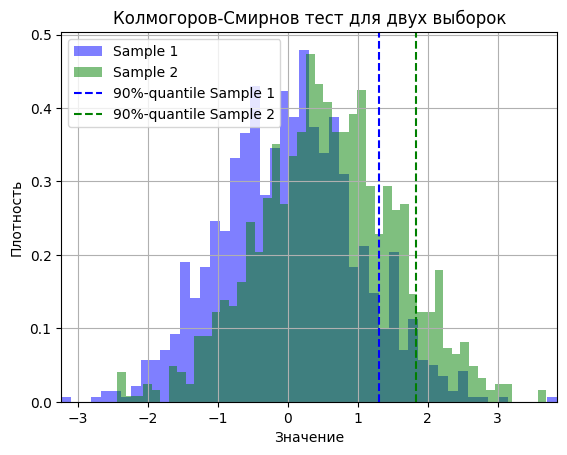

In [17]:
np.random.seed(42)
sample1 = np.random.normal(loc=0, scale=1, size=1000)
sample2 = np.random.normal(loc=0.5, scale=1, size=1000)


ks_stat, p_value = ks_2samp(sample1, sample2)


print(f"KS-statistic: {ks_stat}")
print(f"P-value: {p_value}")


plt.hist(sample1, bins=50, density=True, alpha=0.5, label="Sample 1", color='blue')
plt.hist(sample2, bins=50, density=True, alpha=0.5, label="Sample 2", color='green')


quantile_90_sample1 = np.quantile(sample1, 0.9)
quantile_90_sample2 = np.quantile(sample2, 0.9)


plt.axvline(quantile_90_sample1, color='blue', linestyle='dashed', label="90%-quantile Sample 1")
plt.axvline(quantile_90_sample2, color='green', linestyle='dashed', label="90%-quantile Sample 2")


xmin = min(min(sample1), min(sample2))
xmax = max(max(sample1), max(sample2))
plt.xlim([xmin, xmax])


plt.title("Колмогоров-Смирнов тест для двух выборок")
plt.xlabel("Значение")
plt.ylabel("Плотность")
plt.legend()
plt.grid(True)
plt.show()

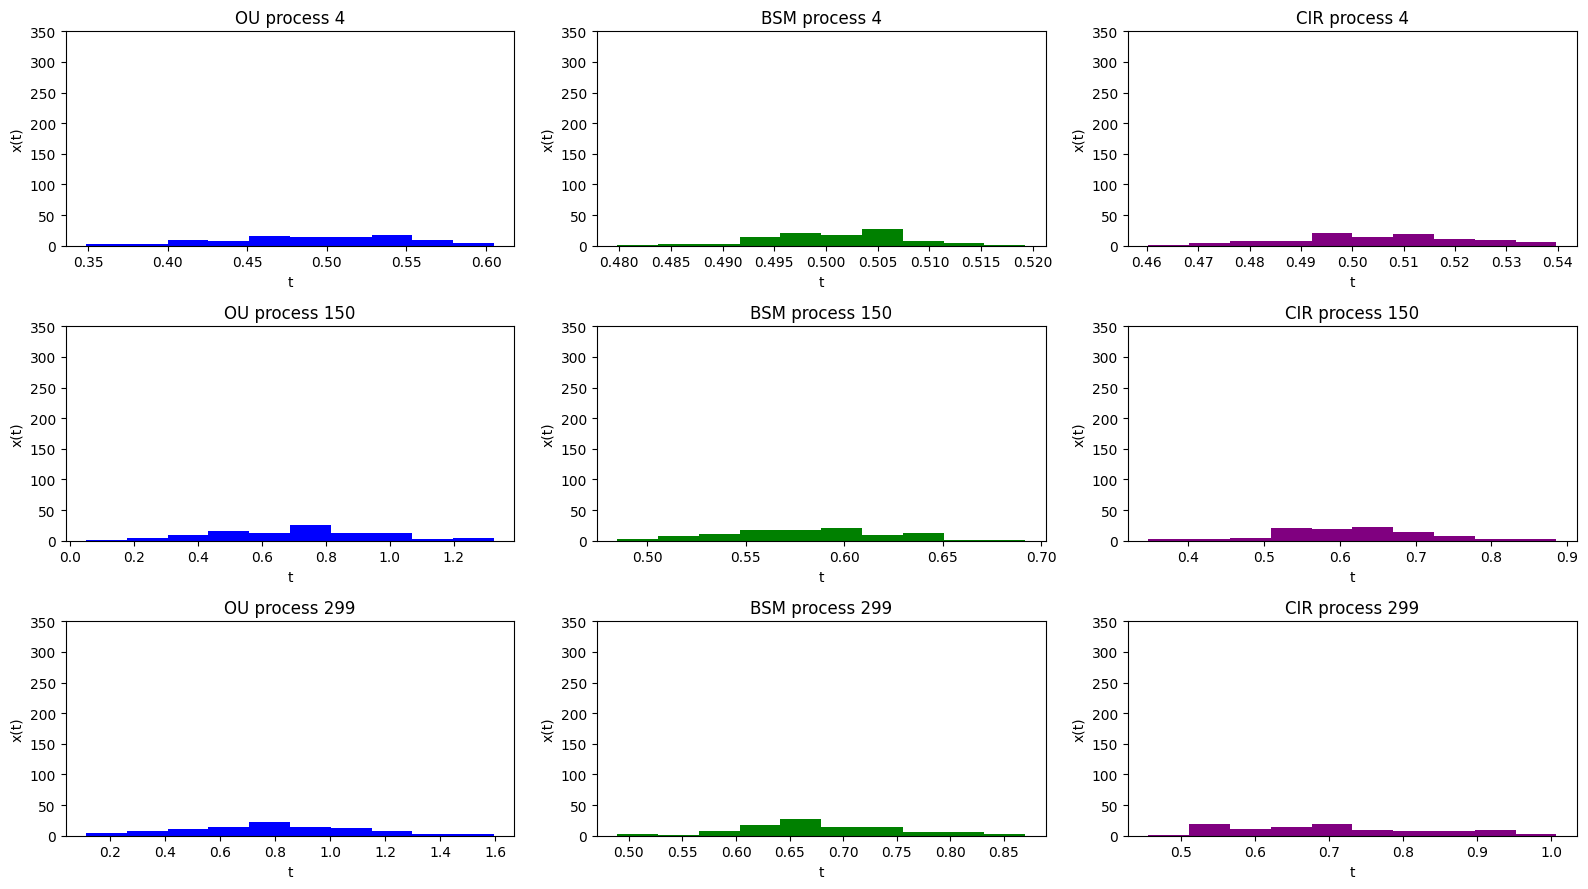

In [29]:
#density function

fig, axs = plt.subplots(3, 3, figsize=(16, 9))

n = 4

axs[0][0].hist(x_data_OU[n], color='blue')
axs[0][0].set_title(f'OU process {n}')

axs[0][1].hist(x_data_BSM[n], color='green')
axs[0][1].set_title(f'BSM process {n}')

axs[0][2].hist(x_data_CIR[n], color='purple')
axs[0][2].set_title(f'CIR process {n}')

n = Nt // 2
axs[1][0].hist(x_data_OU[n], color='blue')
axs[1][0].set_title(f'OU process {n}')

axs[1][1].hist(x_data_BSM[n], color='green')
axs[1][1].set_title(f'BSM process {n}')

axs[1][2].hist(x_data_CIR[n], color='purple')
axs[1][2].set_title(f'CIR process {n}')

n = Nt - 1
axs[2][0].hist(x_data_OU[n], color='blue')
axs[2][0].set_title(f'OU process {n}')

axs[2][1].hist(x_data_BSM[n], color='green')
axs[2][1].set_title(f'BSM process {n}')

axs[2][2].hist(x_data_CIR[n], color='purple')
axs[2][2].set_title(f'CIR process {n}')

for k in range(0, 3):
    for j in range(0, 3):
        axs[k][j].set_ylim(0, 350)
        #axs[k][j].set_xlim(0, 2)
        axs[k][j].set_xlabel('t')
        axs[k][j].set_ylabel('x(t)')

plt.tight_layout()

plt.show()

Task. Perform a normality test on the histograms and present your conclusions.

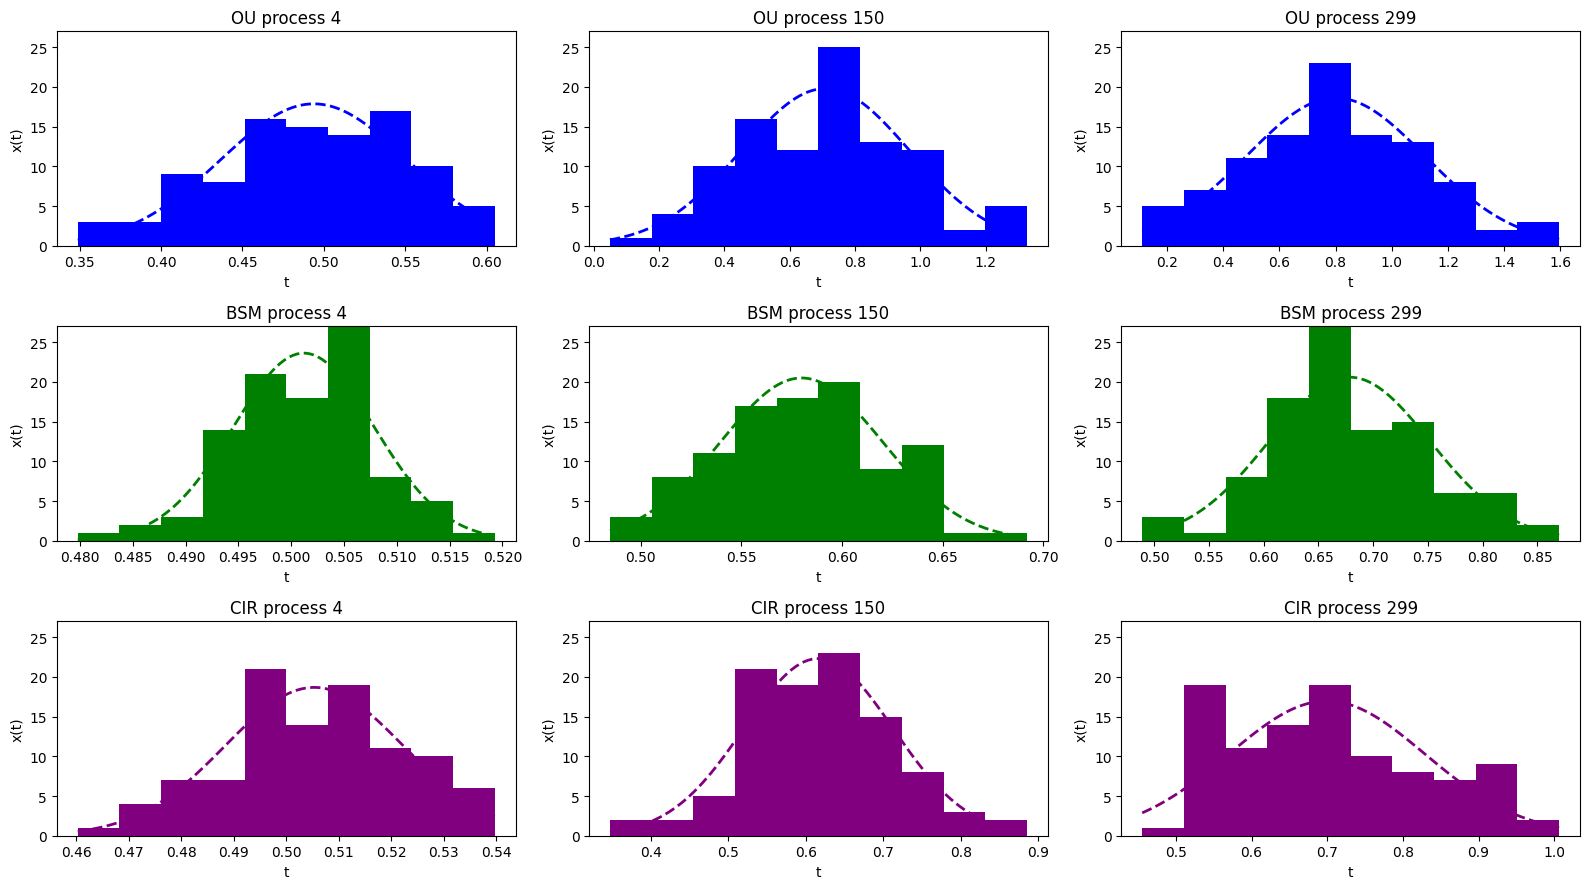

In [30]:
n_values = [4, Nt // 2, Nt - 1]


max_y = max([np.histogram(x_data_OU[n])[0].max() for n in n_values] +
            [np.histogram(x_data_BSM[n])[0].max() for n in n_values] +
            [np.histogram(x_data_CIR[n])[0].max() for n in n_values])

fig, axs = plt.subplots(3, 3, figsize=(16, 9))



def plot_normal(ax, data, color):
    mu, std = np.mean(data), np.std(data)
    x = np.linspace(min(data), max(data), 100)
    p = norm.pdf(x, mu, std)
    ax.plot(x, p * len(data) * np.diff(np.histogram(data, bins=10)[1])[0], color=color, linestyle='dashed', linewidth=2)

for i, n in enumerate(n_values):
    axs[0][i].hist(x_data_OU[n], color='blue', bins=10)
    axs[0][i].set_title(f'OU process {n}')
    plot_normal(axs[0][i], x_data_OU[n], 'blue')

    axs[1][i].hist(x_data_BSM[n], color='green', bins=10)
    axs[1][i].set_title(f'BSM process {n}')
    plot_normal(axs[1][i], x_data_BSM[n], 'green')

    axs[2][i].hist(x_data_CIR[n], color='purple', bins=10)
    axs[2][i].set_title(f'CIR process {n}')
    plot_normal(axs[2][i], x_data_CIR[n], 'purple')

for k in range(3):
    for j in range(3):
        axs[k][j].set_ylim(0, max_y)  
        axs[k][j].set_xlabel('t')
        axs[k][j].set_ylabel('x(t)')

plt.tight_layout()
plt.show()

## Выводы:
* OU процесс имеет высокие значения p-value для обоих тестов на всех временных шагах, что предполагает, что распределение близко к нормальному.
* BSM процесс показывает смешанные результаты на ранних шагах, особенно на временном шаге 4, где p-value для Shapiro-Wilk ниже, что может указывать на отклонение от нормальности. Однако на поздних шагах значения p-value высоки.
* CIR процесс на временных шагах 4 и 150 имеет относительно низкие p-value для Shapiro-Wilk, что может означать, что распределение на этих шагах не является строго нормальным. Однако на шаге 299 значения p-value указывают на нормальность.
* В целом, для большинства процессов и шагов данные показывают хорошие признаки нормальности, особенно на поздних шагах (150 и 299).